<a href="https://colab.research.google.com/github/AnilKumar-06/Movie-Recommandation/blob/main/NetflixRecommandationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('nbagg')

import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [3]:

start = datetime.now()
if not os.path.isfile('data.csv'):
  data = open('data.csv', mode='w')
  row = list()
  files = ['/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_1.txt']#,'/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_2.txt']#, '/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_3.txt', '/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_4.txt']

  for file in files:
    print('Reading rating from {}...'.format(file))
    with open(file) as f:
      for line in f:
        del row[:] #you don't have to do this
        line = line.strip()
        if line.endswith(':'):
          #all below are rating for this movie, until another
          movie_id = line.replace(':', '')
        else:
          row = [x for x in line.split(',')]
          row.insert(0, movie_id)
          data.write(','.join(row))
          data.write('\n')

    print('Done.\n')
  data.close()
  print('Time taken :',datetime.now() - start)

Reading rating from /content/drive/MyDrive/ML_Projects/NetflixRecoomandation/combined_data_1.txt...
Done.

Time taken : 0:00:39.997194


In [4]:
print("Creating the dataframe from data.csv file...")
df = pd.read_csv('data.csv', sep=',',names = ['movie', 'user', 'rating', 'date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

#arranging the rating according to time
print('Sorting the datetime by date...')
df.sort_values(by='date', inplace=True)
print('Done..')

Creating the dataframe from data.csv file...
Done.

Sorting the datetime by date...
Done..


In [5]:
df.head()

,movie,user,rating,date
9056171,1798,510180,5,1999-11-11
14892677,2866,510180,3,1999-11-11
19585852,3730,510180,4,1999-11-11
20393918,3870,510180,2,1999-11-11
6901473,1367,510180,5,1999-11-11


In [6]:
df.describe()['rating']

count    2.405376e+07
mean     3.599634e+00
std      1.086118e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [7]:
# Just to make sure that all NAN containing rows are deleted..

print("Number of Nan values in our dataframe : ", sum(df.isnull().any()))

Number of Nan values in our dataframe :  0


Removing Duplicates

In [8]:
dup_bool = df.duplicated(['movie', 'user', 'rating'])
dups = sum(dup_bool) #by considering all columns..(including timestamp)
print("There are {} duplicate rating entries in the data...".format(dups))

There are 0 duplicate rating entries in the data...


Basic Statistics(# of Rating, # of Users, # of Movies)

In [9]:
print("Total Data")
print("-"*70)
print("\nTotal no. of rating : ",df.shape[0])
print("Total No. of Users : ", len(np.unique(df.user)))
print("Total No. of Movies : ", len(np.unique(df.movie)))

Total Data
----------------------------------------------------------------------

Total no. of rating :  24053764
Total No. of Users :  470758
Total No. of Movies :  4499


Spliting data into Train and Test

In [10]:
if not os.path.isfile('train.csv'):
  #create the dataframe and store it in the disk for offline purpose...
  df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
  #creating the dataframe and store it in the disk for offline purpose...
  df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index = False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

Basic statistic in Train data (# of Ratings # of Users and # of Movies)

In [11]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data")
print("-"*70)
print("\nTotal no of ratings : ",test_df.shape[0])
print("Total no of Users : ", len(np.unique(test_df.user)))
print("Total no. of movies : ", len(np.unique(test_df.movie)))

Training data
----------------------------------------------------------------------

Total no of ratings :  4810753
Total no of Users :  302727
Total no. of movies :  4497


EDA On Train data

In [12]:
def human(num, units = "M"):
  units = units.lower()
  num = float(num)
  if units == 'k':
    return str(num/10**3) + 'K'
  elif units == 'M':
    return str(num/10**6) + 'M'
  elif units == 'b':
    return str(num/10**9) + 'B'


Distribution of ratings

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


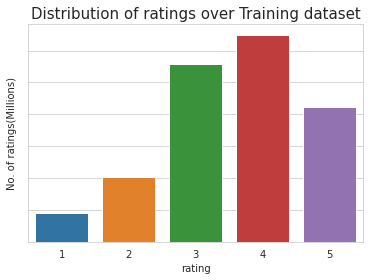

In [13]:
fig, ax = plt.subplots()
plt.title("Distribution of ratings over Training dataset", fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel("No. of ratings(Millions)")
plt.show()

In [14]:
# It is used to skip the warnings 'SettingWithCopyWarning'...
pd.options.mode.chained_assignment = None        #default = 'warn'
train_df['day_of_week'] = train_df.date.dt.day_name()
#df['day_of_week'] = df['mydate'].dt.day_name() 
train_df.head(20)



,movie,user,rating,date,day_of_week
0,1798,510180,5,1999-11-11,Thursday
1,2866,510180,3,1999-11-11,Thursday
2,3730,510180,4,1999-11-11,Thursday
3,3870,510180,2,1999-11-11,Thursday
4,1367,510180,5,1999-11-11,Thursday
5,2948,510180,3,1999-12-06,Monday
6,3421,510180,3,1999-12-06,Monday
7,2478,510180,3,1999-12-06,Monday
8,1615,122223,3,1999-12-08,Wednesday
9,2780,122223,3,1999-12-08,Wednesday


In [15]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count()
no_of_rated_movies_per_user.head()

user
6     105
7     190
10     38
25      2
33      8
Name: rating, dtype: int64

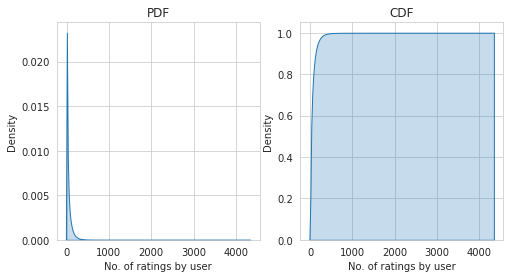

In [16]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel("No. of ratings by user")
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True, ax=ax2)
plt.xlabel("No. of ratings by user")
plt.title('CDF')
plt.show()

In [17]:
no_of_rated_movies_per_user.describe()

count    389223.000000
mean         49.439553
std          71.463434
min           1.000000
25%           8.000000
50%          23.000000
75%          62.000000
max        4326.000000
Name: rating, dtype: float64

In [18]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0, 1.01, 0.01))

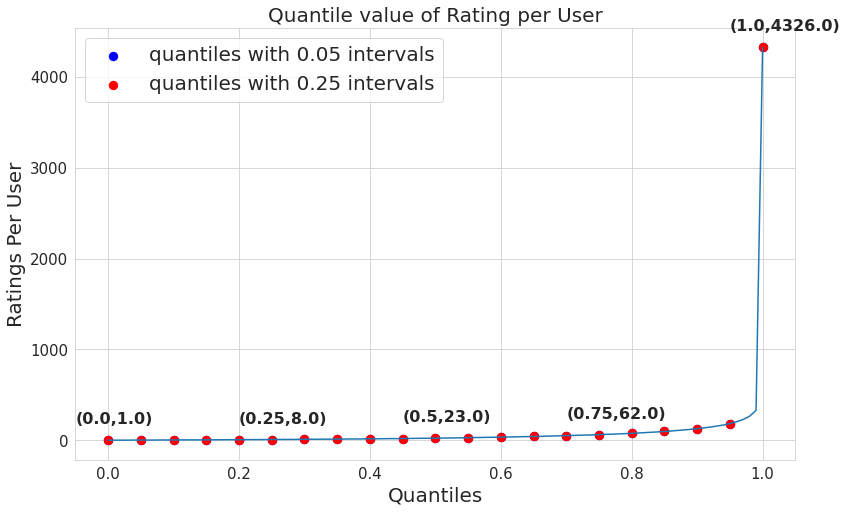

In [19]:
fig = plt.figure(figsize = (10, 6))
axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title("Quantile value of Rating per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y=quantiles.values[::5], c='blue', s=70, label="quantiles with 0.05 intervals")

plt.scatter(x = quantiles.index[::5], y=quantiles.values[::5], c="red", s=70, label = "quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):plt.annotate(s='({},{})'.format(x,y), xy = (x,y),fontweight
                                                                            ='bold', fontsize = 16, xytext=(x-0.05, y+180))

axes.tick_params(labelsize = 15)

In [20]:
quantiles[::5]

0.00       1.0
0.05       2.0
0.10       3.0
0.15       5.0
0.20       6.0
0.25       8.0
0.30      10.0
0.35      13.0
0.40      16.0
0.45      19.0
0.50      23.0
0.55      28.0
0.60      35.0
0.65      42.0
0.70      51.0
0.75      62.0
0.80      77.0
0.85      97.0
0.90     128.0
0.95     184.0
1.00    4326.0
Name: rating, dtype: float64

In [21]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 353210
Total number of ratings above 75th percentile = 36013


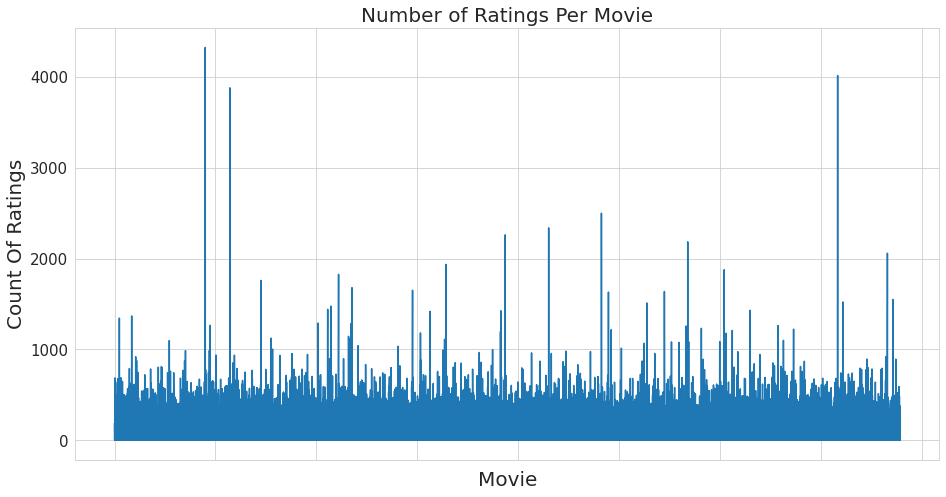

In [22]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize=20)
plt.ylabel("Count Of Ratings", fontsize=20)
plt.plot(no_of_rated_movies_per_user.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

**It is skewed nicely**

It clearly shows that there are some movies which are very popular and were rated by 90% users as comapared to other movies

Number of ratings on each day of the week

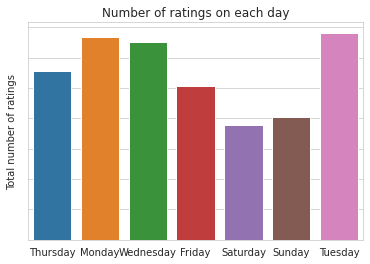

In [23]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data = train_df, ax = ax)
plt.title("Number of ratings on each day")
plt.ylabel('Total number of ratings')
plt.xlabel("")
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

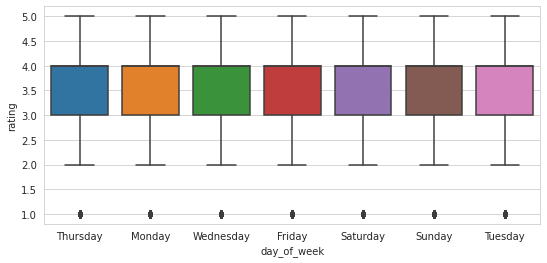

0:00:09.765973


In [24]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now()-start)

In [25]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print('Average Ratings')
print("_"*30)
print(avg_week_df)
print("\n")

Average Ratings
______________________________
day_of_week
Friday       3.576426
Monday       3.573257
Saturday     3.585673
Sunday       3.588731
Thursday     3.577798
Tuesday      3.570347
Wednesday    3.578739
Name: rating, dtype: float64




Creating sparse matrix from data frame

In [26]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
  print("It is present in your pwd, getting it from disk......")
  #just get it from the disk instead of computing it
  train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
  print("Done...")

else:
  print("We are creating sparse matrix from the dataframe.....")
  #create sparse matrix and store it after usages.
  #It should be in such a way that, Matrix[row, col] = data
  train_sparse_matrix = sparse.csr_matrix((train_df.rating.values,(train_df.user.values, train_df.movie.values)),)
  print("Done. It\'s shape is : (user, movie", train_sparse_matrix.shape)
  print("Saving it into disk for further usages...")
  sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
  print("Done.....\n")
  print(datetime.now()-start)

We are creating sparse matrix from the dataframe.....
Done. It's shape is : (user, movie (2649430, 4500)
Saving it into disk for further usages...
Done.....

0:00:14.074386


The sparsity of train sparse matrix

In [27]:
us, mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print("Sparsity of train matrix : {} % ".format((1-elem/(us*mv))*100))

Sparsity of train matrix : 99.83859831485766 % 


Creating sparse matrix from test data frame

In [28]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
  print("It is present in your pwd, getting it from disk....")
  #just get it from the disk instead of computing it.
  test_sparse_matrix = sparse.load_npz("test_sparse_matrix.npz")
  print("Done....")
else:
  print("We are creating sparse matrix from the dataframe....")
  #create sparse_matrix and store it for after usages
  #It should be in such a way that, matrix[row, col] = data
  test_sparse_matrix = sparse.csr_matrix((test_df.rating.values,(test_df.user.values, test_df.movie.values)),)
  print("Done. It\'s shape is : (user, movie):", test_sparse_matrix.shape)
  print("Saving it into disk for further usages....")
  #save it into disk
  sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
  print('Done...\n')
print(datetime.now()-start)

We are creating sparse matrix from the dataframe....
Done. It's shape is : (user, movie): (2649430, 4500)
Saving it into disk for further usages....
Done...

0:00:03.961548


The sparsity of test data matrix

In [29]:
us, mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()
print("sparsity of Test matrix : {} % ".format((1-elem/(us*mv))*100))

sparsity of Test matrix : 99.95964957661752 % 


Finding Global Average of all movies ratings, Averages rating per user, and average rating per movie

In [30]:
#get the averages in dictionary(key:user_id/movie_id, value:avg rating)
def get_average_rating(sparse_matrix, of_users):
  #average rating of user/axes
  ax = 1 if of_users else 0 #1-user axes, 0-Movie axes
  #".AI" is for converting column_matrix to 1-D numpy array
  sum_of_ratings = sparse_matrix.sum(axis=ax).A1
  #Boolean matrix of ratings(whether a user rated movie or not)
  is_rated = sparse_matrix != 0
  #no. of ratings that each user or movie
  no_of_ratings = is_rated.sum(axis=ax).A1
  #max_user and max_movie ids in sparse matrix
  u, m = sparse_matrix.shape
  #create a dictionary of users and their averages ratings..
  averages_ratings = { i :sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i] != 0}
  #return that dictionary of average rating
  return averages_ratings


Finding global average of all movie ratings

In [31]:
train_averages = dict()
#get the global avetrage of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.577584765710522}

Finding average rating per users

In [32]:
train_averages['user'] = get_average_rating(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 : ',train_averages['user'][10])



Average rating of user 10 :  3.263157894736842


Finding average rating per movie

In [33]:
train_averages['movie'] = get_average_rating(train_sparse_matrix, of_users=False)
print('\nAverages rating of movie 15 :',train_averages['movie'][15])


Averages rating of movie 15 : 3.312741312741313


PDF's & CDF's of Avg ratings of users and movies(In Train data)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

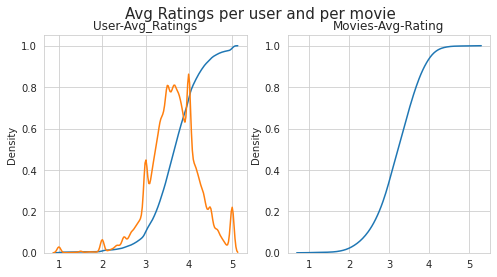

0:00:07.270932


In [34]:
start = datetime.now()
#draw pdfs for averages rating per user and average
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle("Avg Ratings per user and per movie",fontsize=15)
ax1.set_title('User-Avg_Ratings')
#get the list average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False,kde_kws=dict(cumulative=True),label='Cdf')
sns.distplot(user_averages, ax=ax1,hist=False,label='pdf')

ax2.set_title('Movies-Avg-Rating')
#get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, kde_kws=dict(cumulative=True),label='pdf')
plt.show()
print(datetime.now()-start)

Cold start Problem with users

In [35]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users-users_train

print('\nTotal number of users : ',total_users)
print('\nNumber of Users in train data : ',users_train)
print("\nNumber of users that did not appear in train data : {}({} %)".format(new_users,np.round((new_users/total_users)*100, 2)))


Total number of users :  470758

Number of Users in train data :  389223

Number of users that did not appear in train data : 81535(17.32 %)


Cold start problem with movies

In [36]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies-movies_train

print('\nTotal number of movies : ',total_movies)
print('\nNumber of User in train data : ',movies_train)
print("\n No of movies that did not appear in train data : {}({} %)".format(new_movies, np.round((new_movies/total_movies)*100,2)))


Total number of movies :  4499

Number of User in train data :  4403

 No of movies that did not appear in train data : 96(2.13 %)


Computing Similarity matrices

**Computing user-user Similarity matrix**

1. Caculating user user Similarity_matrix is not very easy(unless you have huge Computing Power and lots of time) because of number of usersbeing lare


In [37]:
from sklearn.metrics.pairwise import cosine_similarity
def compute_user_similarity(sparse_matrix, compute_for_few=False, top=100, verbose=False,
                            verb_for_n_rows = 20,draw_time_taken = True):
  no_of_users, _ = sparse_matrix.shape
  #get the indices of non zero rows(users) from our sparse matrix
  row_ind, col_ind = sparse_matrix.nonzero()
  row_ind = sorted(set(row_ind))
  time_taken = list() #time taken forn finding similar users for an user...
  # we create row,cols and data list.., which can be used to create sparse matrices
  rows, cols,data = list(), list(), list()
  if verbose: print("Computing top",top,"similarities for each user...")
  start = datetime.now()
  tmp=0
  for row in row_ind[:top] if compute_for_few else row_ind:
    tmp += 1
    prev = datetime.now()

    #get the similarity row for this user with all other users
    sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
    #we will get only the 'top' most similar users and ignore rest of them
    top_sim_ind = sim.argsort()[-top:]
    top_sim_val = sim[top_sim_ind]
    
    #add them to our row, cols and data
    rows.extend([row]*top)
    cols.extend(top_sim_ind)
    data.extend(top_sim_val)
    time_taken.append(datetime.now().timestamp() - prev.timestamp())

    if verbose:
      if tmp%verb_for_n_rows == 0:
        print("computing done for {} users [time elased : {} ]".format(tmp, datetime.now()-start))


    # lets create sparse matrix out of these and return it
  if verbose: print("Creating sparse matrix from the computed similarities")

      #return rows, cols, data

  if draw_time_taken:
    plt.plot(time_taken, label = 'time taken for each user')
    plt.plot(np.cumsum(time_taken), label='Total time')
    plt.legend(loc='best')
    plt.xlabel('User')
    plt.ylabel('Time(seconds)')
    plt.show()
  return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken

Computing top 40 similarities for each user...
computing done for 20 users [time elased : 0:00:13.869401 ]
computing done for 40 users [time elased : 0:00:27.913733 ]
Creating sparse matrix from the computed similarities


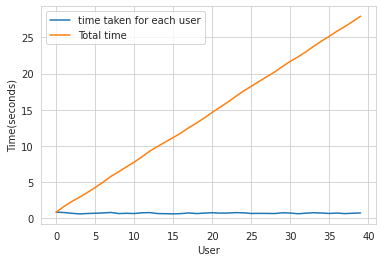

----------------------------------------------------------------------------------------------------
Time taken : 0:00:30.792384


In [38]:
# We are not going to run it on whole data it will gives us memory error or so we will try it on 100
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 40,verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

Trying with reduced dimensions (Using TruncatedSVD for dimensionality reduction of user vector)
We have 405,041 users in out training set and computing similarities between them..( 17K dimensional vector..) is time consuming..
From above plot, It took roughly 8.88 sec for computing simlilar users for one user
We have 405,041 users with us in training set.
${ 405041 \times 8.88 = 3596764.08  \sec } =  59946.068 \min = 999.101133333 \text{ hours}
= 41.629213889 \text{ days}...$

Even if we run on 4 cores parallelly (a typical system now a days), It will still take almost 10 and 1/2 days.
IDEA: Instead, we will try to reduce the dimentsions using SVD, so that it might speed up the process...



In [39]:
from datetime import datetime
from sklearn.decomposition import TruncatedSVD
start = datetime.now()
#initilize the algorithm with some parameter
#All of them are default except n_component. n_iter is for randomized SVD solver
netflix_svd = TruncatedSVD(n_components=40, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)
print(datetime.now()-start)

0:00:56.033282



Here,

$\sum \longleftarrow$ (netflix_svd.singular_values_ )

$\bigvee^T \longleftarrow$ (netflix_svd.components_)

$\bigcup$ is not returned. instead Projection_of_X onto the new vectorspace is returned.

It uses randomized svd internally, which returns All 3 of them saperately. Use that instead.

In [40]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)


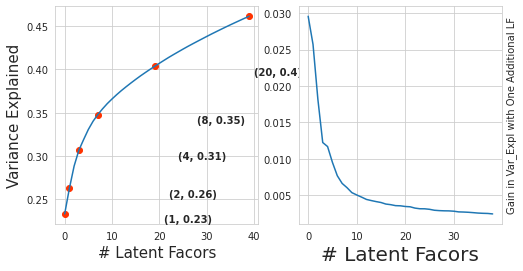

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Facors", fontsize=15)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
ind = [1, 2,4,8,20,40]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)



ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=20)

plt.show()

In [42]:
for i in ind:
  print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

(1, 0.23)
(2, 0.26)
(4, 0.31)
(8, 0.35)
(20, 0.4)
(40, 0.46)


In [43]:
#lets project our original U_M matrix into 40 Dimentional space
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print(datetime.now()-start)

0:00:00.874729


In [44]:
type(trunc_matrix), trunc_matrix.shape

(numpy.ndarray, (2649430, 40))

Lets Convert this to actual sparse matrix and store it for future purpose

In [45]:
if not os.path.isfile("trunc_sparse_matrix.npz"):
#create that sparse matrix
  trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
#save this truncated sparse matrix for later usage
  sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
  trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')


In [46]:
trunc_sparse_matrix.shape

(2649430, 40)

Computing top 50 similarities for each user...
computing done for 10 users [time elased : 0:00:06.160163 ]
computing done for 20 users [time elased : 0:00:12.270195 ]
computing done for 30 users [time elased : 0:00:18.327492 ]
computing done for 40 users [time elased : 0:00:24.429720 ]
computing done for 50 users [time elased : 0:00:30.486985 ]
Creating sparse matrix from the computed similarities


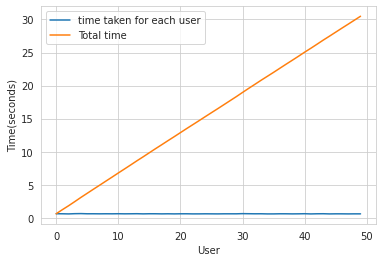

__________________________________________________
time: 0:00:32.859497


In [47]:
#getting memory error
start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few = True, top=50, verbose=True, verb_for_n_rows=10)
print("_"*50)
print("time:",datetime.now()-start)

**Computing Movies-Movies Similarity matrix**





In [48]:
start = datetime.now()
if not os.path.isfile("Movie_Movie_sim_sparse.npz"):
  print("It seems you don't have that file. Computing movie_movie similarity..")
  start = datetime.now()
  m_m_sim_sparse = cosine_similarity(X = train_sparse_matrix.T, dense_output=False)
  print("Done...")
  #store this sparse matrix in disk before using it. For future purposes.
  print("Saving it to disk without the need of re-computing it again...")
  sparse.save_npz("movie_movie_sim_sparse.npz",m_m_sim_sparse)
  print("Done...")
else:
  print("It is there, we will get it.")
  m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
  print("Done...")

print(datetime.now() - start)

It seems you don't have that file. Computing movie_movie similarity..
Done...
Saving it to disk without the need of re-computing it again...
Done...
0:00:33.148240


In [49]:
m_m_sim_sparse.shape

(4500, 4500)

Even though we have similarity measure 
of each movie, with all other movies, we generally don't care much about least similar movies.

Most of the times, only top_xxx similar items matters. It may be 10 or 100.

We take only those top similar movie rating and store them in a saperate dictionary



In [50]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [51]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
  #get the top similar movies and store them in the dictionary
  sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
  similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

#just testing similar movies for movie_15
similar_movies[15]

0:00:02.190880


array([4424, 3755,  590, 3973, 1720, 2818, 4095, 3162, 2280, 2450, 2534,
       1072, 1416, 3338,  376,  598, 2187, 1942, 2716,  565, 1690, 4376,
        847, 1510, 2429, 3706, 1030, 2399, 4486, 2879, 4467, 3502, 2107,
       1391,  882,  509, 3726, 2215, 2637, 4037, 3580, 1493, 3602,  610,
        791, 2764,   31, 3511,  218, 3329, 1696, 2636, 1335,   61, 4326,
       1149, 1184, 4175, 4276, 2859, 2827, 1453, 1177,  280, 1874,  772,
       2219, 3396,  327, 3741, 3016,  914,  714,  679, 2545, 3616, 1647,
       2061, 3294, 1494, 2902, 1930, 4163, 3940, 1575, 4079,  756, 4090,
       1351, 4223, 3941, 3279, 2774, 4006,  917,  277, 2419, 2761, 2624,
       1249])

**Finding most similar movies using similarity matrix**

Does Similarity really work as the way we expected?

Lets pick some random movie and check for its similar movies..

In [53]:
#First lets load the movie details into soe dataframe
#movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("/content/drive/MyDrive/ML_Projects/NetflixRecoomandation/movie_titles.csv", sep=',',header=None, names=['movie_id','year_of_release','title'],
                           verbose=True, index_col = 'movie_id', encoding='ISO-8859-1')
movie_titles.head()

Tokenization took: 6.09 ms
Type conversion took: 10.72 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
